In [1]:
!wget -q -nc https://raw.githubusercontent.com/pseprivamirakbarnejad/cmput206lab/master/Lab8/Refim.png
!wget -q -nc https://raw.githubusercontent.com/pseprivamirakbarnejad/cmput206lab/master/Lab8/Inputim.png
!ls

Inputim.png  Refim.png	sample_data


accumulator:


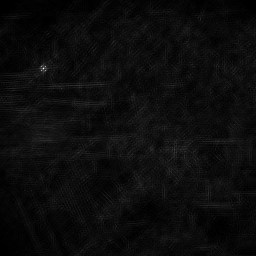

<Figure size 432x288 with 0 Axes>

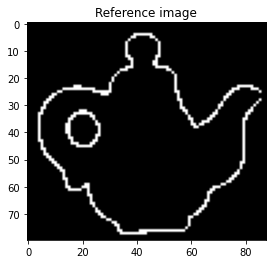

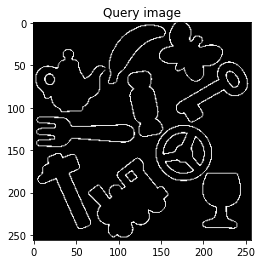

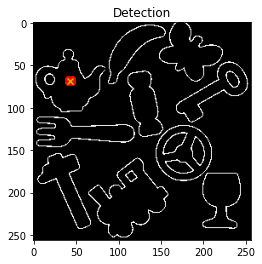

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from skimage.io import imread
from skimage import feature
from scipy.ndimage.filters import sobel
from google.colab.patches import cv2_imshow

# Good for the b/w test images used
MIN_CANNY_THRESHOLD = 10
MAX_CANNY_THRESHOLD = 50
    
def gradient_orientation(image):
    '''
    Calculate the gradient orientation for edge point in the image
    '''
    #calculate dx, dy by passing the image to sobel operator
    dx= sobel(image,0)
    dy = sobel(image,1)
    #calculate gradient with dy, dx and convert it into degree from radian
    radian = np.arctan2(dy,dx)
    gradient = radian * (180/np.pi)

    
    return gradient
    
def build_r_table(image, origin):
    '''
    Build the R-table from the given shape image and a reference point
    '''
    edges = feature.canny(image, low_threshold=MIN_CANNY_THRESHOLD, high_threshold=MAX_CANNY_THRESHOLD)
    gradient = gradient_orientation(edges)
    
    r_table = defaultdict(list)
    for (i,j),value in np.ndenumerate(edges):
        # when there is value, over the indices [gradient[i,j] of r_table, append (origin[0]-i, origin[1]-j)
        #your codes here
        if value: 
          r_table[gradient[i,j]].append((origin[0]-i, origin[1]-j))
        
    return r_table 

def accumulate_gradients(r_table, grayImage):
    '''
    Perform a General Hough Transform with the given image and R-table
    '''
    #get edges with canny
    #your code here
    edges = feature.canny(grayImage, low_threshold=MIN_CANNY_THRESHOLD, high_threshold=MAX_CANNY_THRESHOLD)

    #get gradient by calling gradient_orientation with edges
    #your code here
    gradient = gradient_orientation(edges)
    #initialize accumulator as similar size as grayImage
    #your code here
    h= grayImage.shape[0]
    w= grayImage.shape[1]

    accumulator = np.zeros((h,w), dtype='int64')
    
    for (i,j),value in np.ndenumerate(edges):
        if value:
            for r in r_table[gradient[i,j]]:
                accum_i, accum_j = i+r[0], j+r[1]
                #check the validity of the indices , accum_i and accum_j and increment accumuator
                #your code here
                if (accum_i< accumulator.shape[0] and accum_j < accumulator.shape[1]):
                  accumulator[int(accum_i), int(accum_j)] += 1

    print('accumulator:')
    cv2_imshow(accumulator)

    return accumulator

def general_hough_closure(reference_image):
    '''
    Generator function to create a closure with the reference image and origin
    at the center of the reference image
    
    Returns a function f, which takes a query image and returns the accumulator
    '''
    
    #initialize referencePoint with center of the reference imag
    #your code here
    h= reference_image.shape[0]
    w= reference_image.shape[1]
    referencePoint = (h/2,w/2)
    
    #buid the r_table by calling build_r_table with appropriate parameter
    #your code here
    r_table = build_r_table(reference_image, referencePoint)
    
    #write down the function f(query_image) which returns output of the function accumulate_gradients()
    def f(query_image):
        #your code here
        return accumulate_gradients(r_table, query_image)
    return f

def n_max(a, n):
    '''
    Return the N max elements and indices in a
    '''
    indices = a.ravel().argsort()[-n:]
    indices = (np.unravel_index(i, a.shape) for i in indices)
    return [(a[i], i) for i in indices]

def test_general_hough(gh, reference_image, query):
    '''
    Uses a GH closure to detect shapes in an image and create nice output
    '''
    query_image = imread(query)
    
    #initialize accumulator by calling gh with query_image
    #your code here
    accumulator = gh(query_image)

    plt.clf()
    plt.gray()
    
    plt.figure()
    plt.title('Reference image')
    plt.imshow(reference_image)
    
    plt.figure()
    plt.title('Query image')
    plt.imshow(query_image)    
   
    plt.figure()
    plt.title('Detection')
    plt.imshow(query_image)
    
    # top 5 results in red
    # update m by calling n_max()
    #your code here
    m = n_max(accumulator,5)

    y_points = [pt[1][0] for pt in m]
    x_points = [pt[1][1] for pt in m] 
    plt.scatter(x_points, y_points, marker='o', color='r')

    # top result in yellow
    i,j = np.unravel_index(accumulator.argmax(), accumulator.shape)
    plt.scatter([j], [i], marker='x', color='y')
    
    d,f = os.path.split(query)[0], os.path.splitext(os.path.split(query)[1])[0]
    plt.savefig(os.path.join(d, f + '_output.png'))

    return

  
def test():
    im1ref = 'Refim.png'
    im1in = 'Inputim.png'
    reference_image = imread(im1ref)
    detect_s = general_hough_closure(reference_image)
    test_general_hough(detect_s, reference_image,im1in)

if __name__ == '__main__':
    test()
    